# MLE parameter estimation for an LG-SSM using SGD

## Setup

In [1]:
import sys
from jax import numpy as jnp
import jax.random as jr
from matplotlib import pyplot as plt

sys.path.append("../../..")
sys.path.append("../..")

# Our codebase
from continuous_discrete_linear_gaussian_ssm import ContDiscreteLinearGaussianSSM as MySSM

# from dynamax.linear_gaussian_ssm import LinearGaussianConjugateSSM as MySSM
from dynamax.utils.utils import monotonically_increasing

/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Data



Sampling from CD distributions: this may be a poor approximation if you're simulating from a non-linear SDE. It is a highly appropriate choice for linear SDEs.
Sampling from continuous-discrete linear Gaussian SSM distributions


(0.0, 99.0)

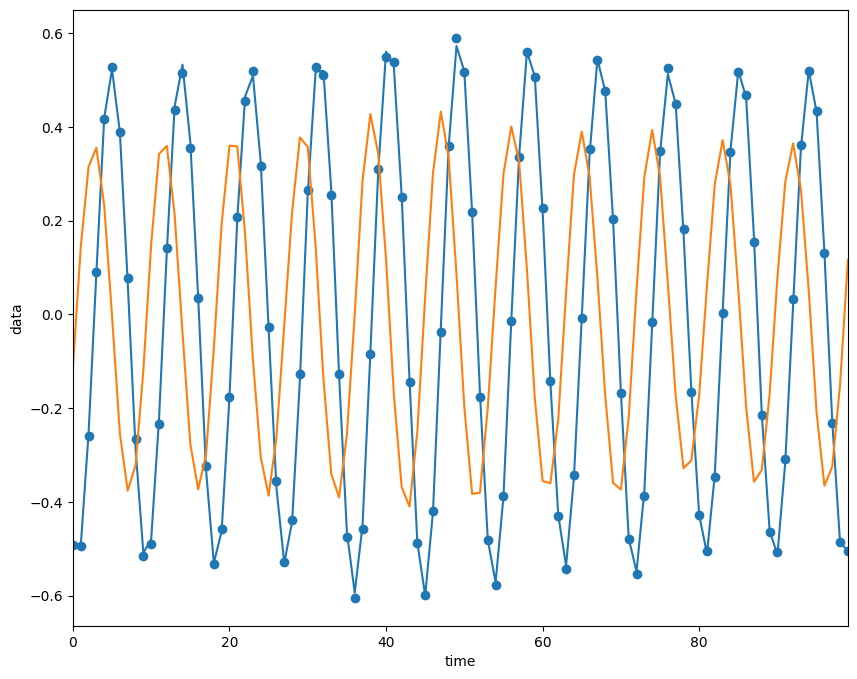

In [2]:
state_dim=2
emission_dim=1
num_timesteps=100
key = jr.PRNGKey(0)

# Model def
inputs = None  # Not interested in inputs for now
true_model = MySSM(state_dim, emission_dim)

# Initialize, controlling what is learned
from continuous_discrete_linear_gaussian_ssm.models import *
true_params, param_props = true_model.initialize(
    key,
    ## Initial
    initial_mean = {
            "params": jnp.array([0.0, 0.0]),
            "props": ParameterProperties()
    },
    initial_cov = {
        "params": 0.1* jnp.eye(true_model.state_dim),
        "props": ParameterProperties(constrainer=RealToPSDBijector())
    },
    ## Dynamics
    dynamics_weights = {
        "params": jnp.array([[0.0, 1.0],
                               [-0.5, 0.0]]),
        "props": ParameterProperties()
    },
    dynamics_diffusion_coefficient = {
        "params": 0.01*jnp.eye(true_model.state_dim),
        "props": ParameterProperties()
    },
    dynamics_diffusion_cov = {
        "params": jnp.eye(true_model.state_dim),
        "props": ParameterProperties(constrainer=RealToPSDBijector())
    },
    ## Emission
    emission_weights = {
        "params": jnp.array([[1.0, 0]]),
        "props": ParameterProperties()
    },
    emission_cov = {
        "params": 0.00005* jnp.eye(true_model.emission_dim),
        "props": ParameterProperties(constrainer=RealToPSDBijector())
    }
)


# data gen
# def generate_sorted_gamma_array(N, shape_param, scale_param, rng_key):
#     # Generate random values from a gamma distribution.
#     gamma_values = jr.gamma(rng_key, shape_param, shape=(N,)) * scale_param
#     # Sort the array.
#     sorted_values = jnp.sort(gamma_values)
#     return sorted_values

# shape_param = 2.0  # Shape parameter of the gamma distribution
# scale_param = 10.0  # Scale parameter of the gamma distribution
# rng_key = jr.PRNGKey(0)  # Initialize a random key
# t_emissions = generate_sorted_gamma_array(num_timesteps, shape_param, scale_param, rng_key)
# t_emissions = t_emissions[:,None]
# print(t_emissions)
t_emissions = jnp.arange(num_timesteps)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key,
                                            num_timesteps=num_timesteps,
                                            # t_emissions=t_emissions
                                          )

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states)
ax.scatter(t_emissions, emissions + 3 * jnp.arange(emission_dim))
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_xlim(0, t_emissions[-1])

## Plot results

In [3]:
def plot_learning_curve(marginal_lls, true_model, true_params, emissions):
    plt.figure()
    plt.xlabel("iteration")
    nsteps = len(marginal_lls)
    plt.plot(marginal_lls, label="estimated")
    true_logjoint = (
        true_model.log_prior(true_params) \
            + true_model.marginal_log_prob(
                true_params,
                emissions,
                filter_hyperparams=KFHyperParams()
            )
    )
    plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
    plt.ylabel("marginal joint probability")

    # Adjust y-axis limits
    y_min = min(min(marginal_lls), true_logjoint) * 1.1  # 10% lower than the smallest value
    y_max = max(max(marginal_lls), true_logjoint) * 1.1  # 10% higher than the largest value
    plt.ylim([y_min, y_max])
    plt.yscale('symlog')
    plt.autoscale(enable=True, axis="x", tight=True)
    plt.legend()

In [4]:
def plot_scalar(true_val, test_val, title):
    plt.figure()
    plt.bar(["True", "Test"], [true_val, test_val])
    plt.title(title)
    plt.ylabel("Value")
    plt.show()

def plot_vector(true_val, test_val, title):
    x = jnp.arange(len(true_val))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, true_val, width, label='True')
    plt.bar(x + width/2, test_val, width, label='Test')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_matrix(matrix, title):
    plt.figure()
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

def compare_parameters(true_params, test_params):
    for level_key, inner_tuple in true_params._asdict().items():
        for param_key, true_value in inner_tuple._asdict().items():
            test_value = getattr(getattr(test_params, level_key), param_key)

            title = f"{level_key} - {param_key}"
            if jnp.isscalar(true_value):
                plot_scalar(true_value, test_value, title)
            elif true_value.ndim == 1:
                plot_vector(true_value, test_value, title)
            elif true_value.ndim == 2:
                plot_matrix(true_value, title + " (True Matrix)")
                plot_matrix(test_value, title + " (Test Matrix)")

                # Vectorize matrices and plot
                true_vectorized = true_value.flatten()
                test_vectorized = test_value.flatten()
                plot_vector(true_vectorized, test_vectorized, title + " (Vectorized)")    

In [5]:
def plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions):
    # run the smoother w/ test_params on emissions data
    # We set dt_final=1 so that predicted mean and covariance at the end of sequence match those of discrete filtering
    kf_hyperparams=KFHyperParams(dt_final = 1.)
    smoothed_emissions, smoothed_emissions_std = test_model.posterior_predictive(test_params, emissions, filter_hyperparams=kf_hyperparams)

    t_emissions = t_emissions.squeeze()
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(t_emissions, emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(t_emissions, smoothed_emissions[:, i] + spc * i,
                        label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            t_emissions,
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, t_emissions[-1])
    plt.ylabel("true and predicted emissions")
    plt.legend()
    plt.show()

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


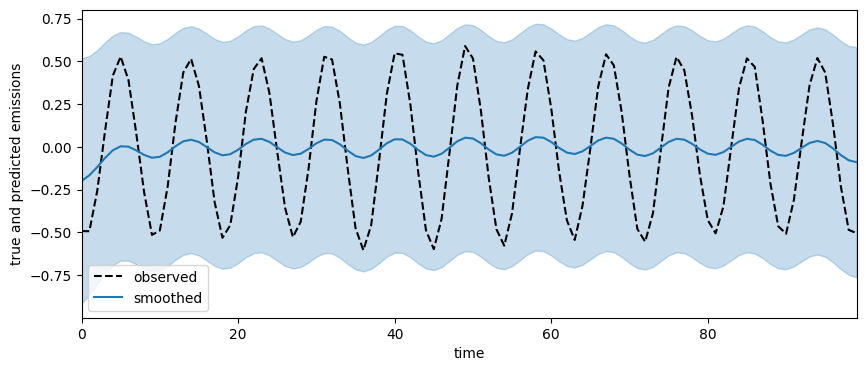

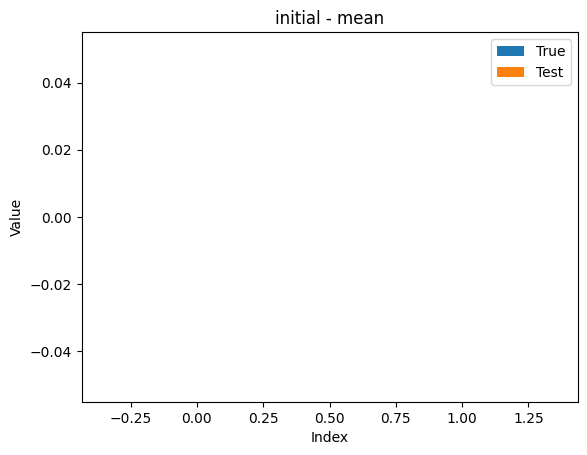

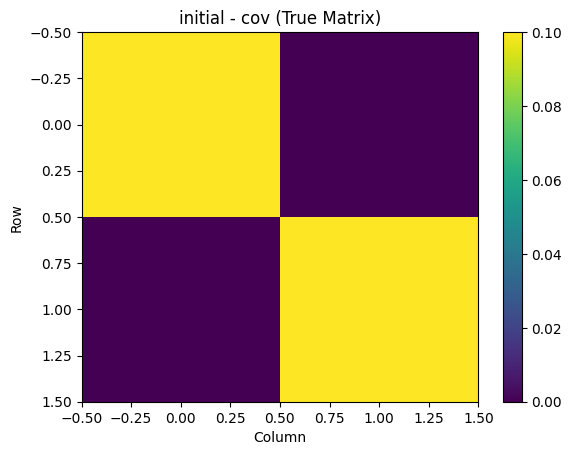

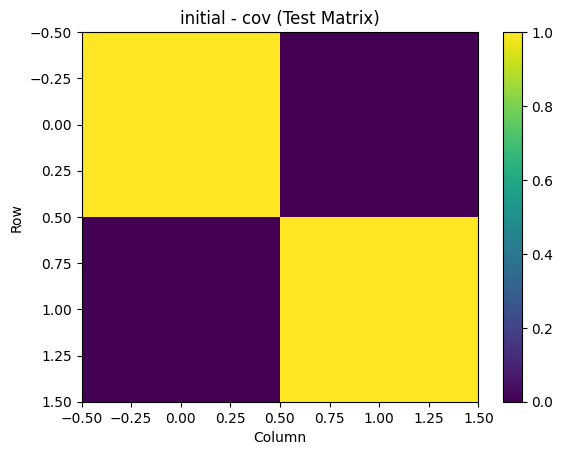

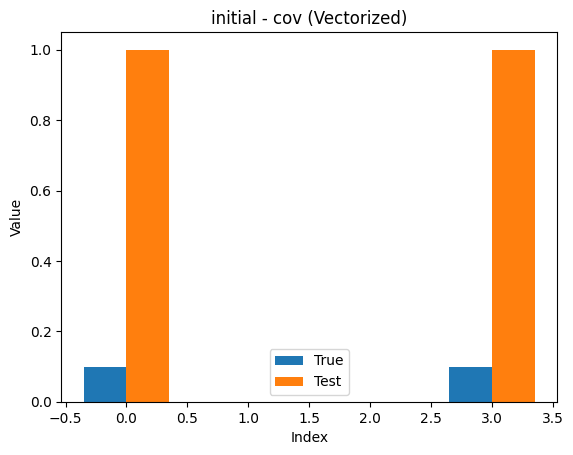

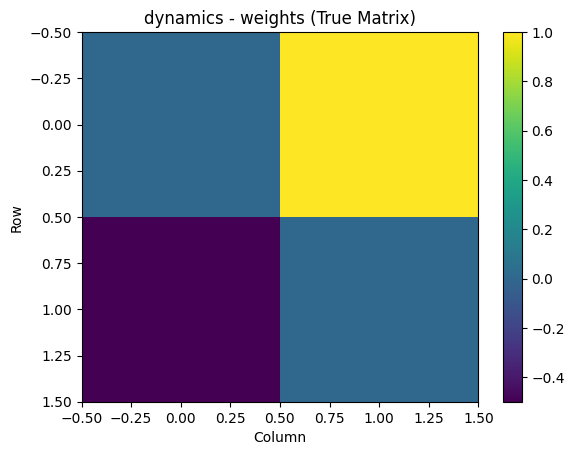

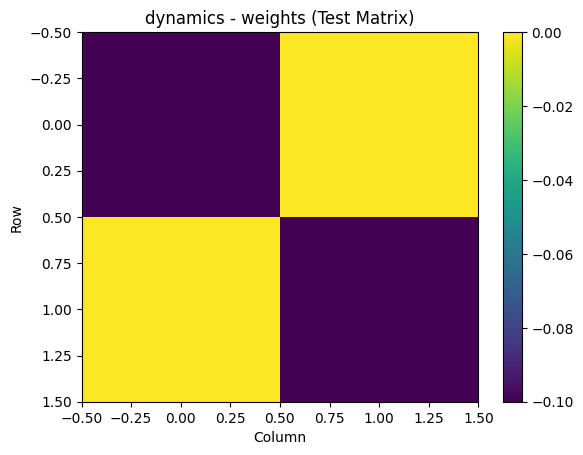

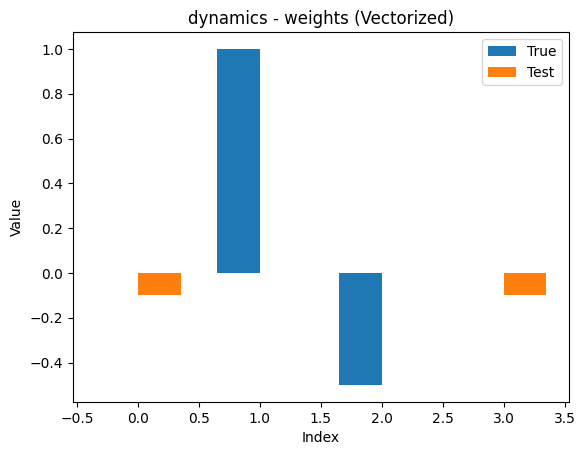

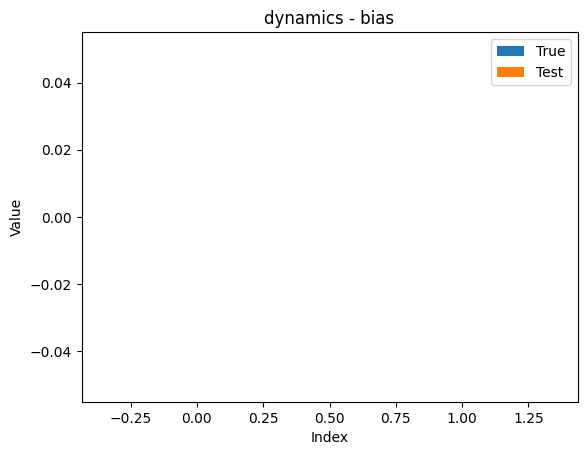

/tmp/ipykernel_41627/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


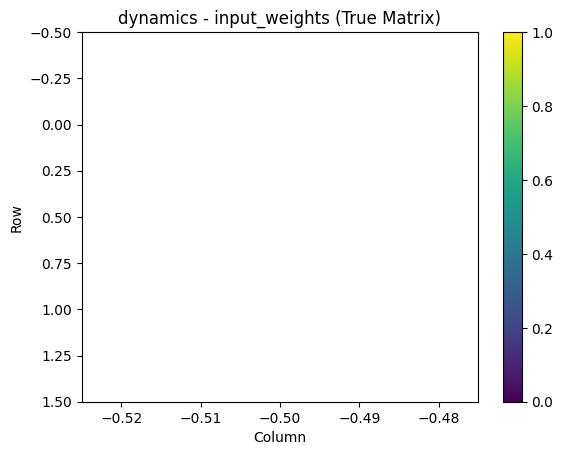

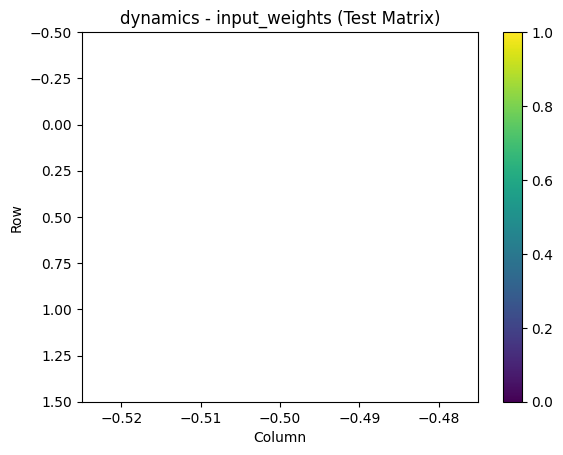

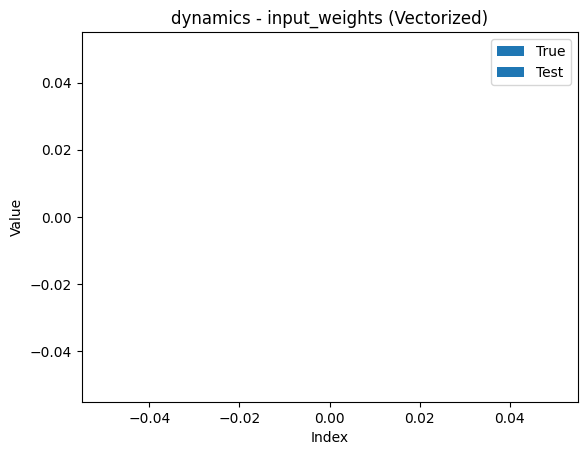

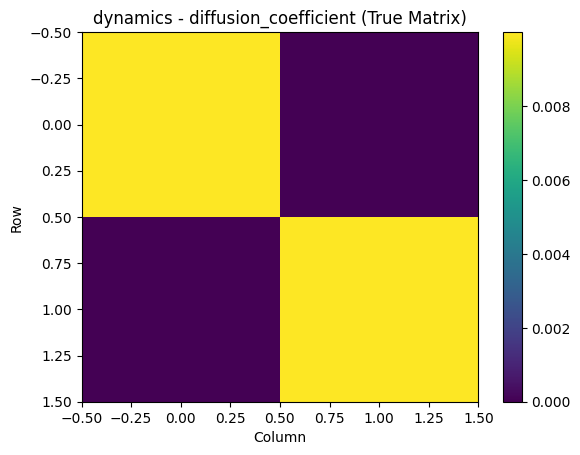

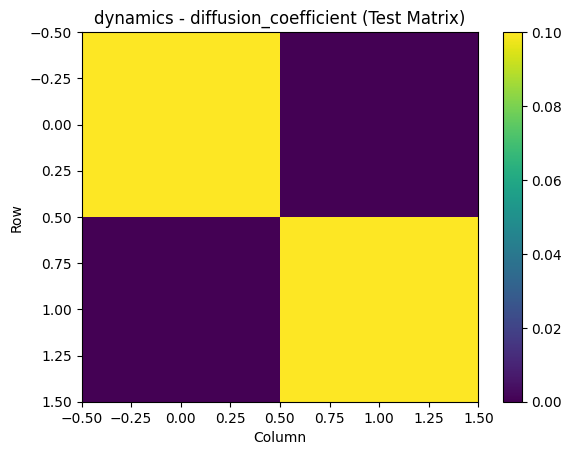

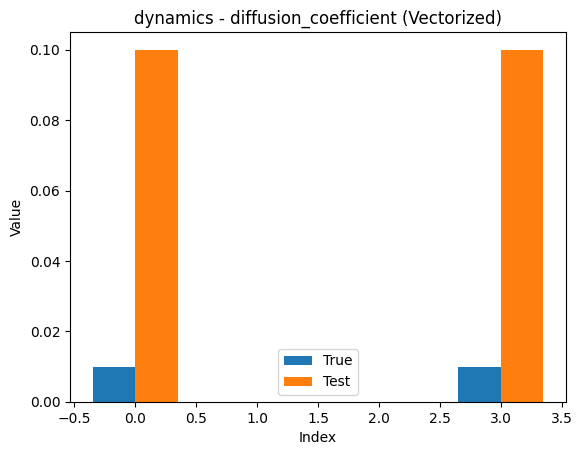

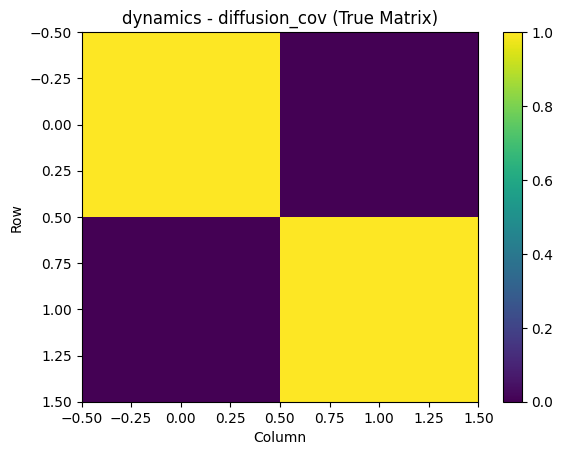

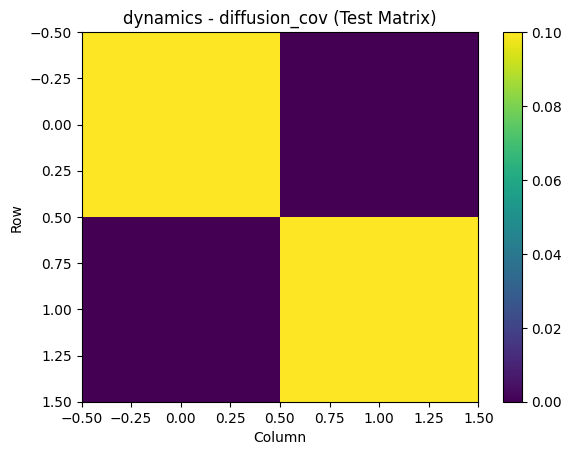

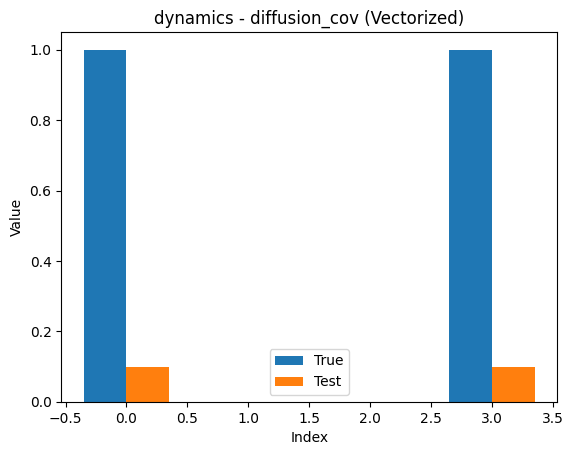

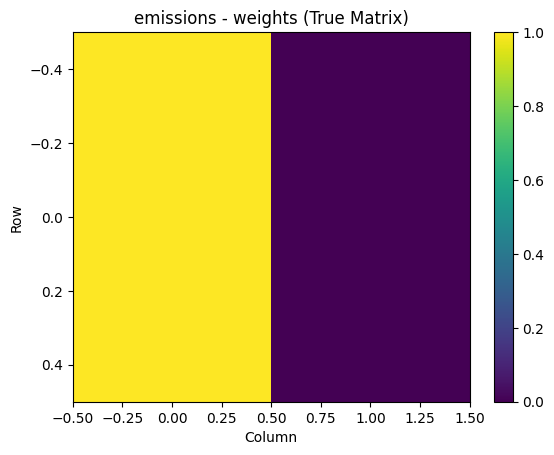

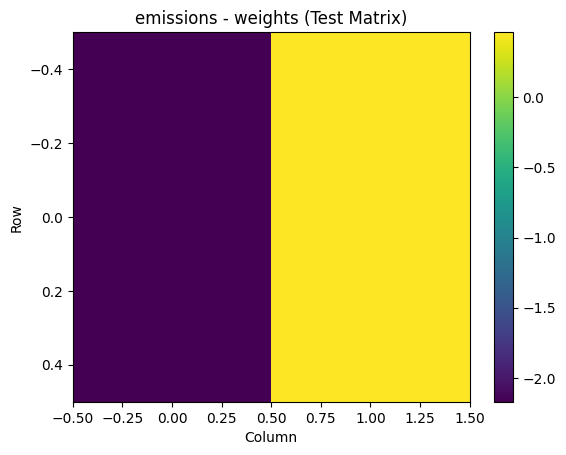

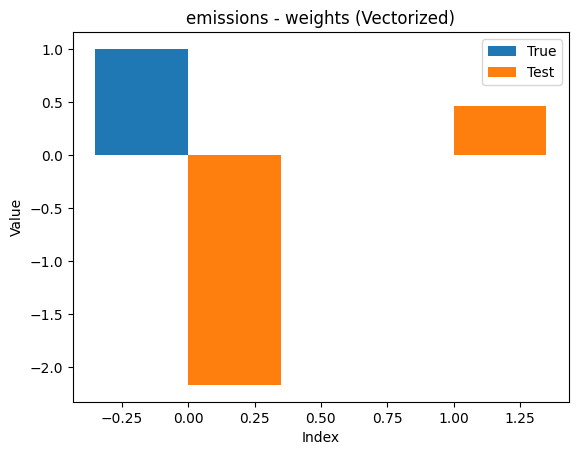

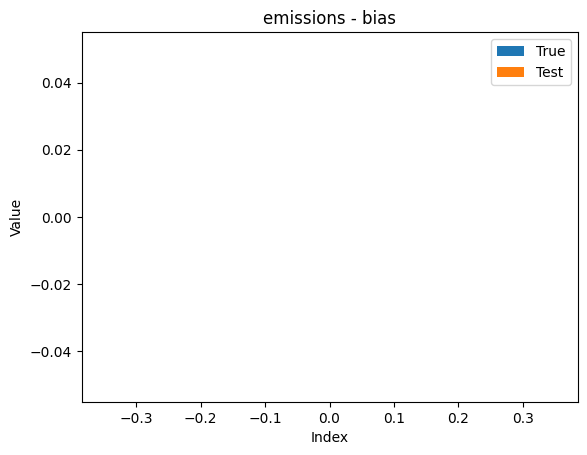

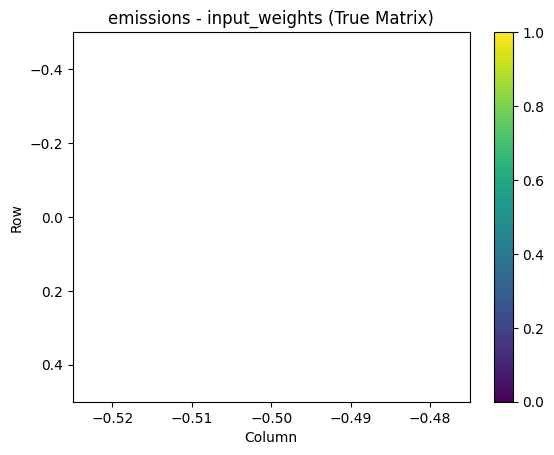

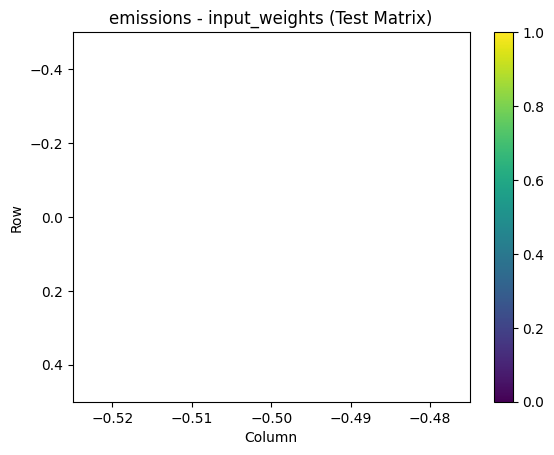

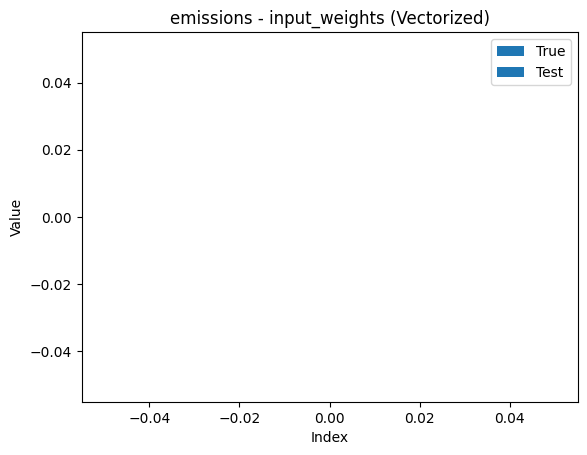

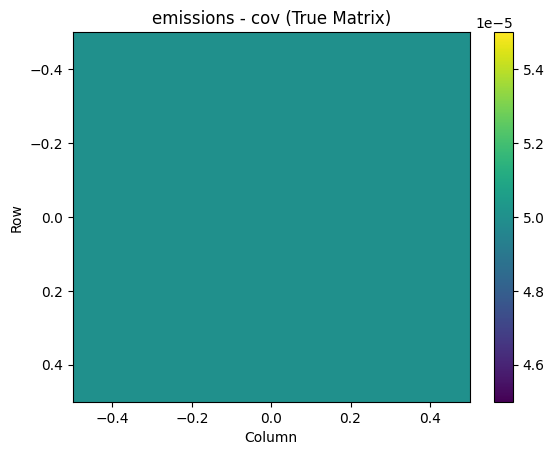

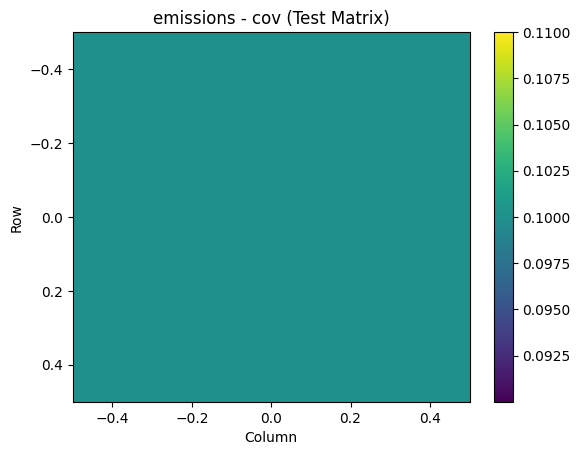

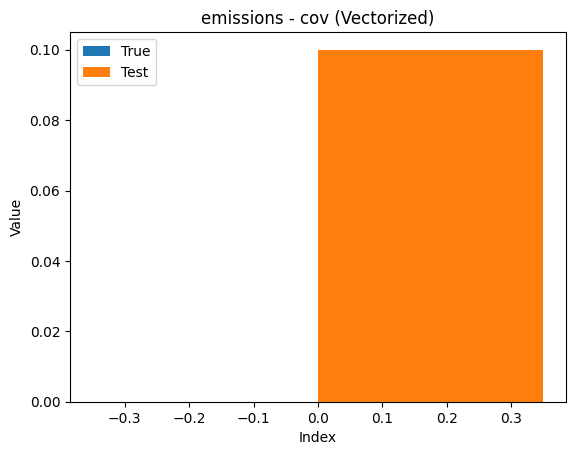

In [6]:
# Plot predictions from a random, untrained model
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
test_params, test_param_props = test_model.initialize(key)

plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions)
compare_parameters(true_params, test_params)

## Fit with SGD

In [7]:
# Define a new test model, that is trainable
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(0)
test_params, test_param_props = test_model.initialize(
    key,
    ## Initial
    initial_mean = {
            "params": jnp.zeros(test_model.state_dim),
            "props": ParameterProperties(trainable=True) # Learn the initial mean
    },
    initial_cov = {
        "params": jnp.eye(true_model.state_dim),
        "props": ParameterProperties(constrainer=RealToPSDBijector(), trainable=False) # Assume we know the initial covariance
    },
    ## Dynamics
    dynamics_weights = {
        "params": jnp.zeros((true_model.state_dim, true_model.state_dim)),
        "props": ParameterProperties(trainable=True) # Learn the dynamics weights
    },
    dynamics_diffusion_coefficient = {
        "params": jnp.eye(true_model.state_dim),
        "props": ParameterProperties(trainable=True) # Learn the diffusion coefficient
    },
    dynamics_diffusion_cov = {
        "params": jnp.eye(true_model.state_dim),
        "props": ParameterProperties(constrainer=RealToPSDBijector(), trainable=False) # Keep the diffusion covariance fixed
    },
    ## Emission
    emission_weights = {
        "params": true_params.emissions.weights,
        "props": ParameterProperties(trainable=False) # Assume we know what the partial observability is
    },
    emission_cov = {
        "params": true_params.emissions.cov,
        "props": ParameterProperties(constrainer=RealToPSDBijector(), trainable=True) # Assume we know the emission covariance
    },
)

In [8]:
# Optax optimizer
import optax
num_epochs = 1000
my_optimizer = optax.adam(1e-3)

# Fit with SGD
test_params, neg_marginal_lls = test_model.fit_sgd(
    test_params,
    test_param_props,
    emissions,
    filter_hyperparams=KFHyperParams(), # Default KF 
    optimizer=my_optimizer,
    num_epochs=num_epochs,
)
marginal_lls = -neg_marginal_lls * emissions.size

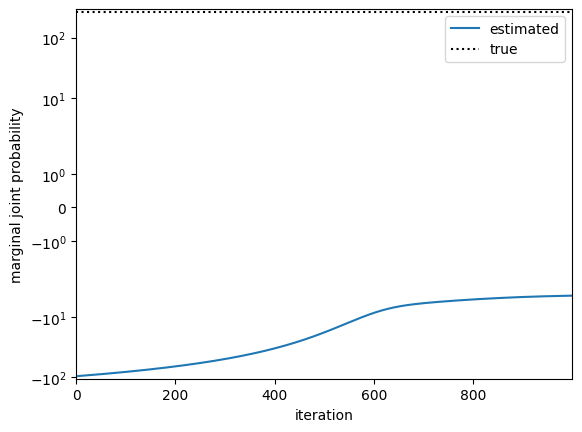

In [9]:
plot_learning_curve(
    marginal_lls,
    true_model,
    true_params,
    emissions
)

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


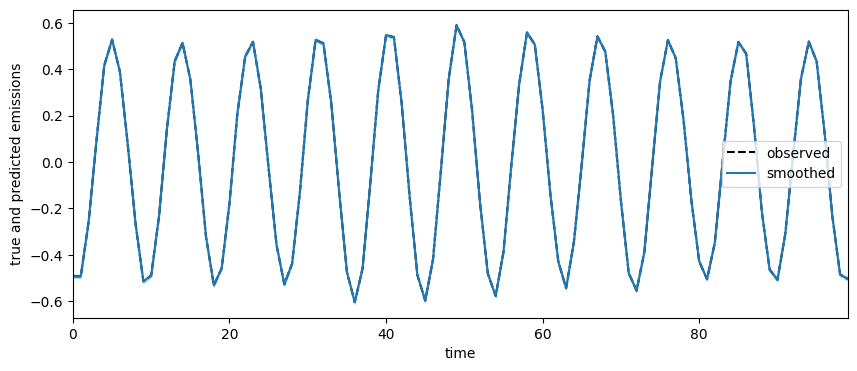

In [10]:
plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions)


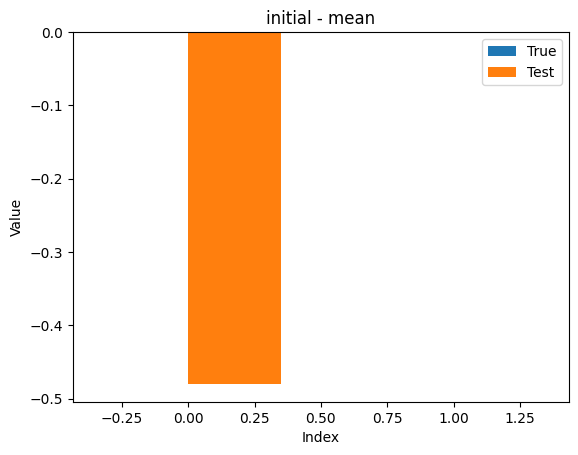

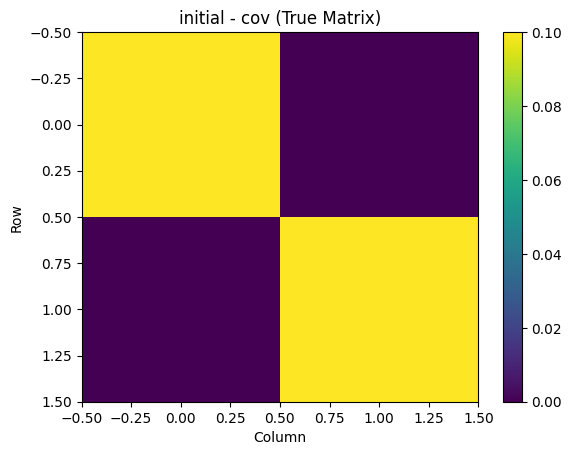

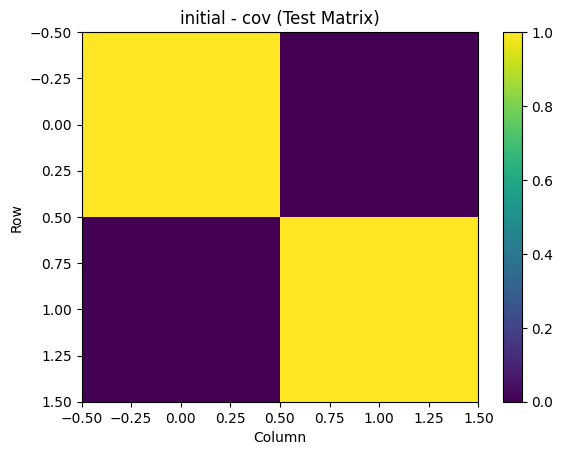

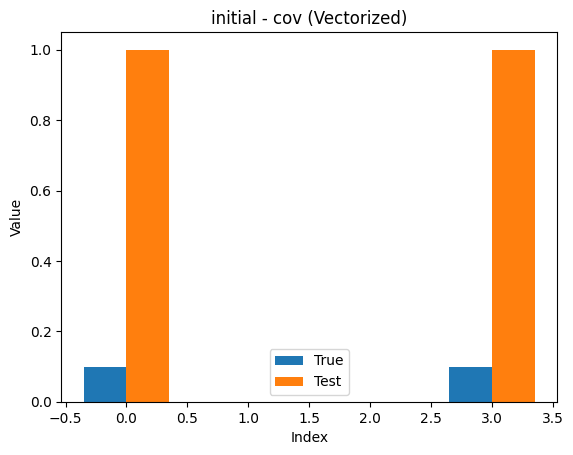

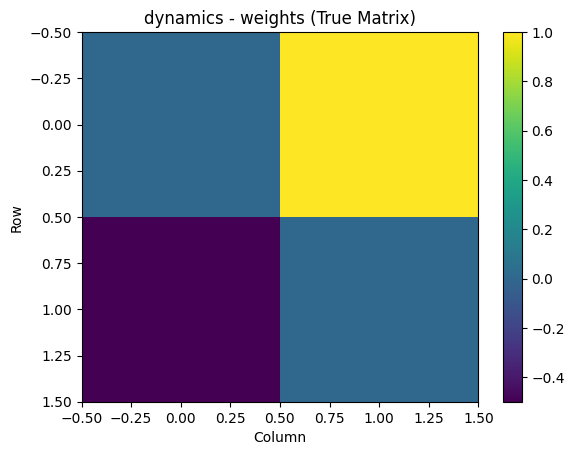

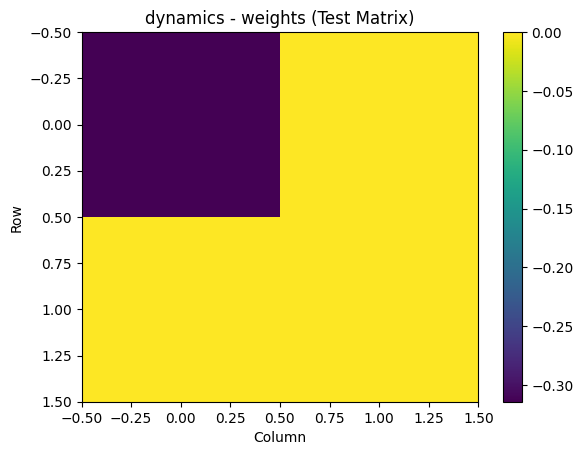

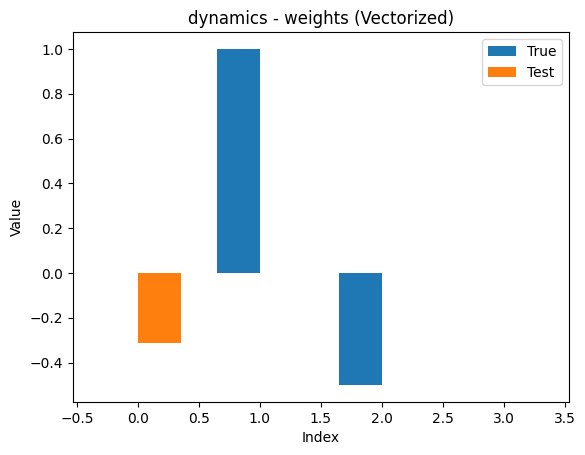

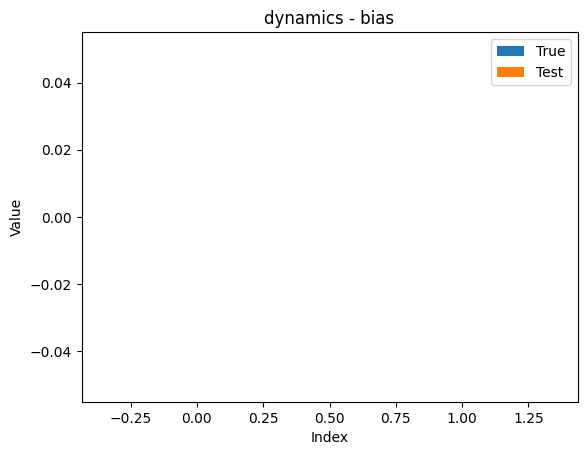

/tmp/ipykernel_41627/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


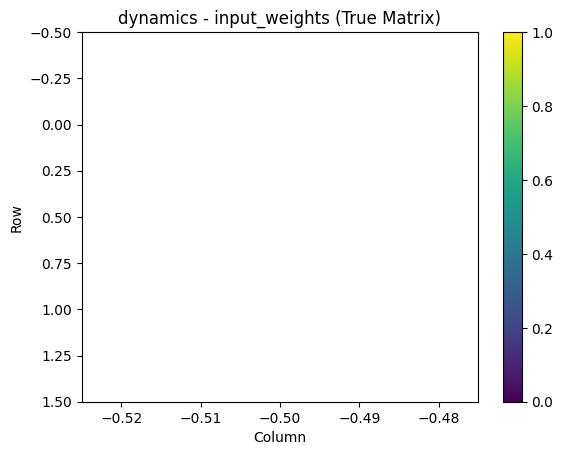

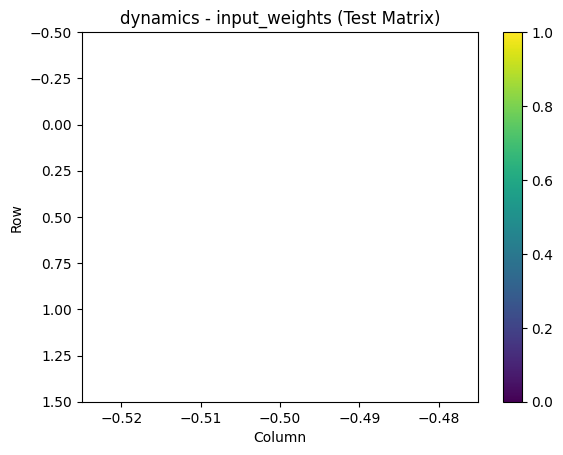

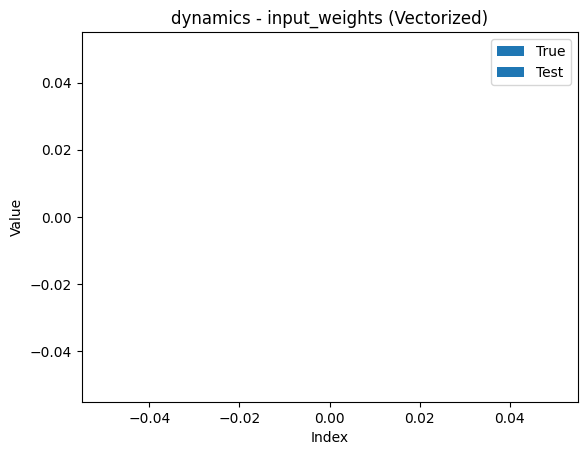

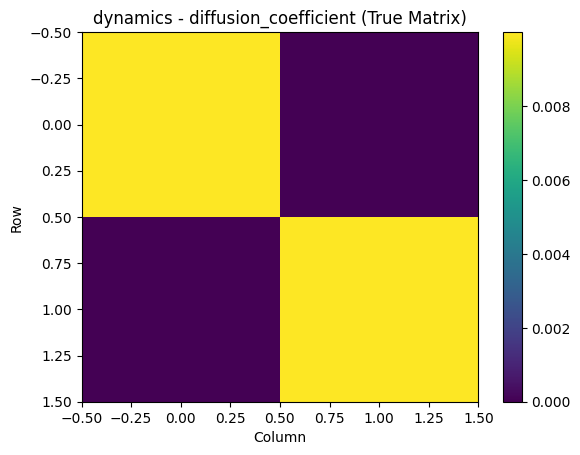

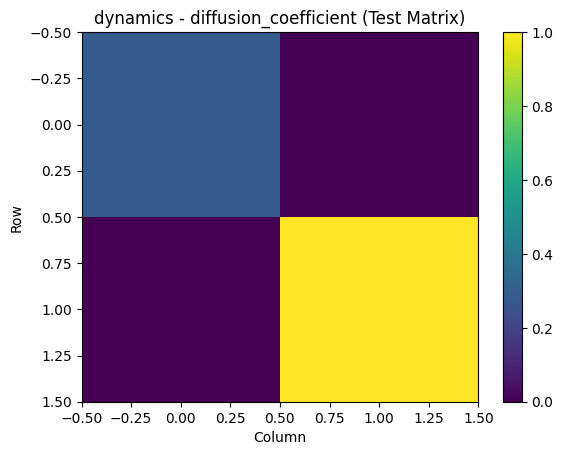

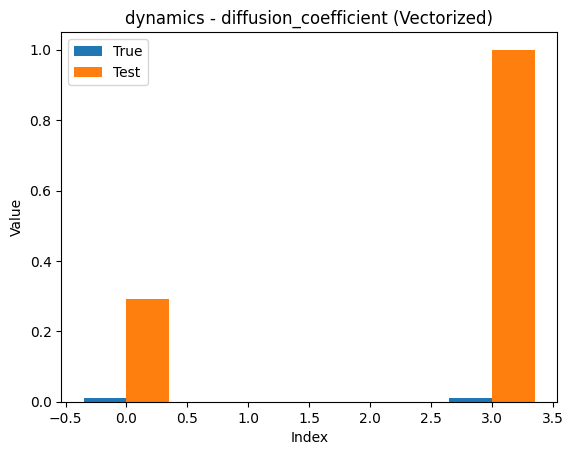

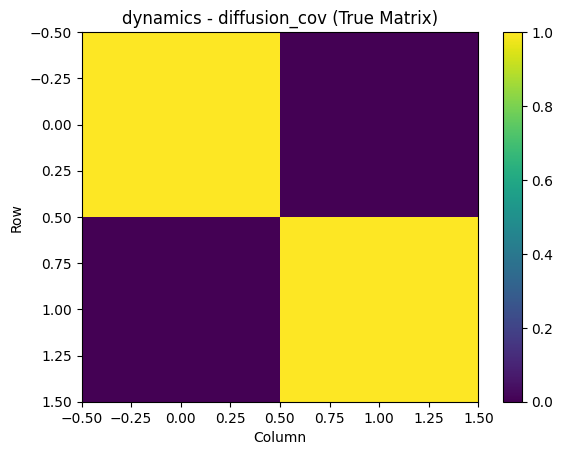

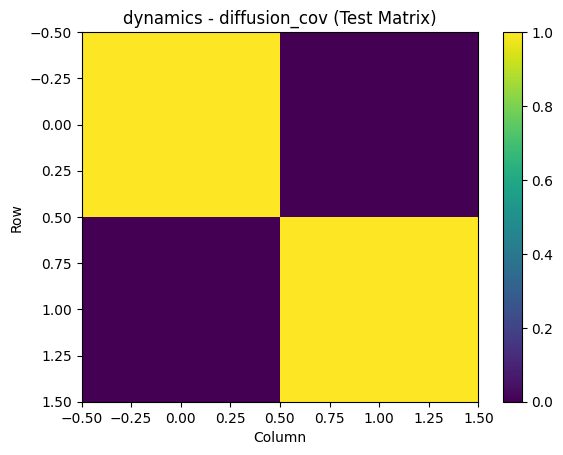

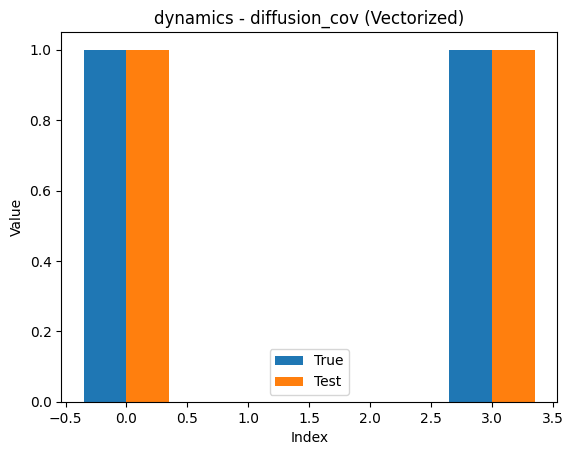

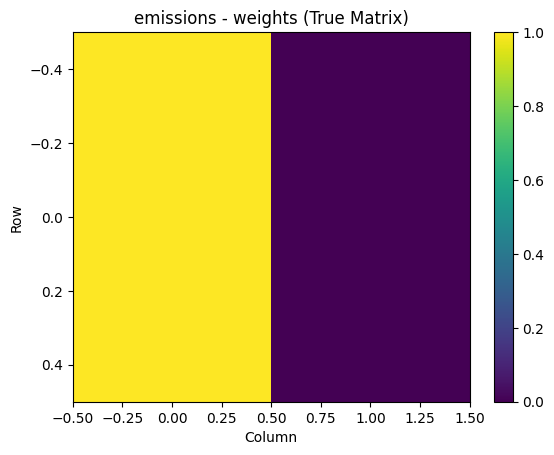

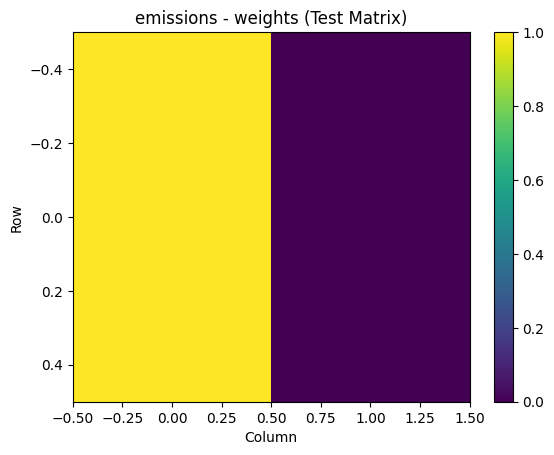

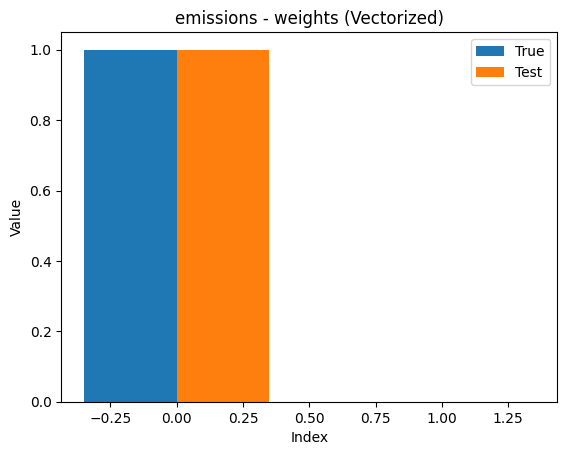

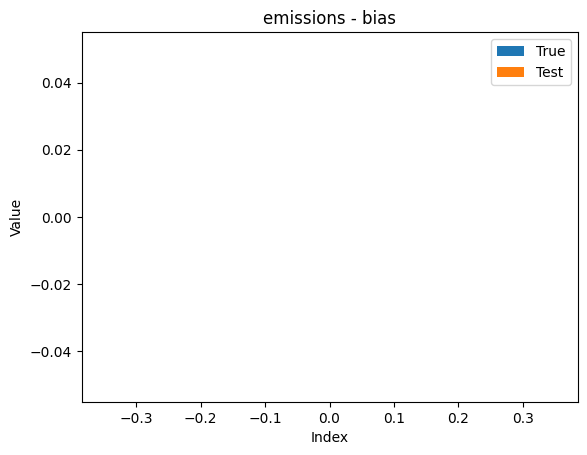

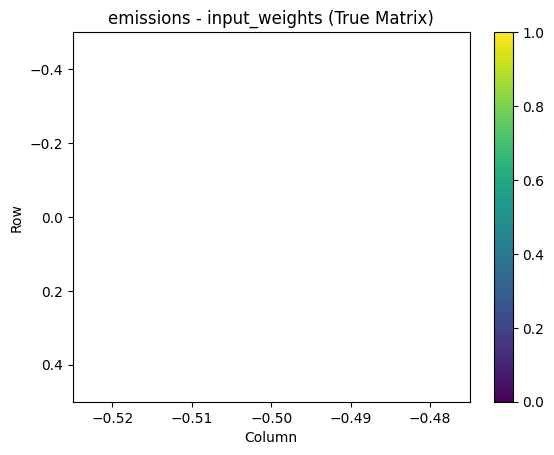

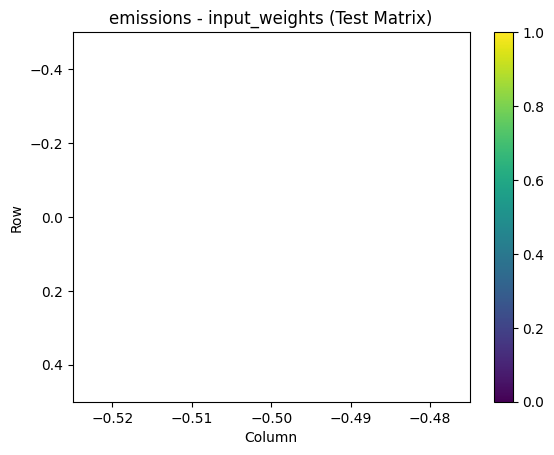

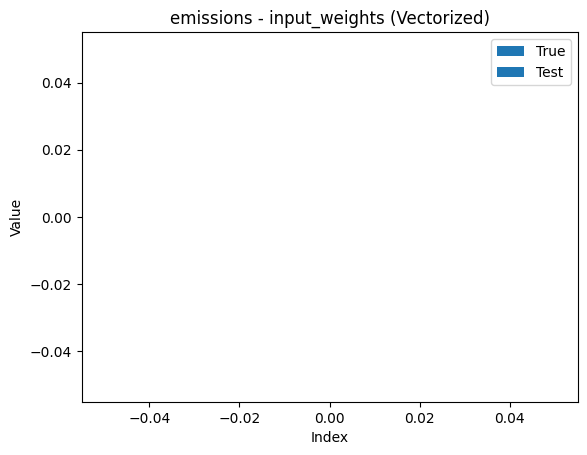

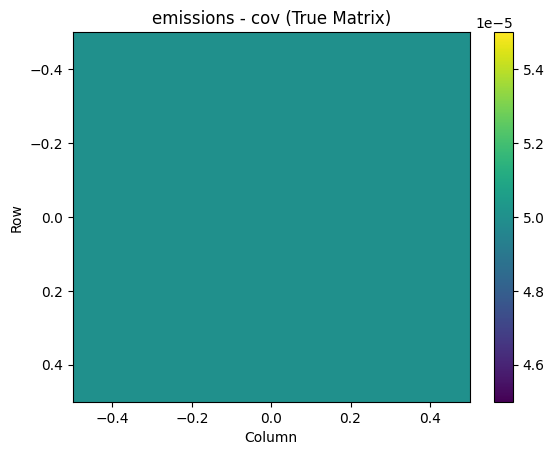

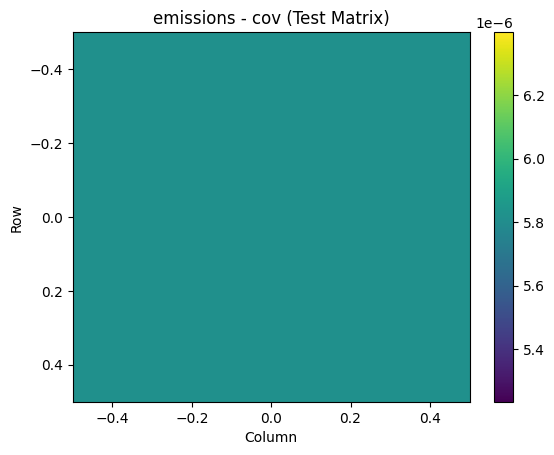

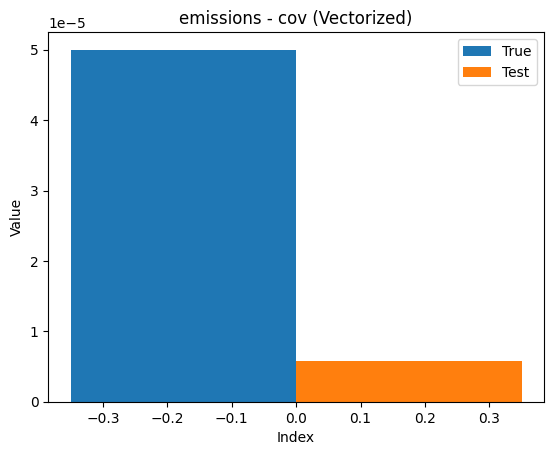

In [11]:
compare_parameters(true_params, test_params)